In [5]:
import jax
import jax.numpy as jnp 
import flax.linen as nn


# Fixed Point Iteration as a Layer
Solving the following problem:

$$
z = tanh(W*z + x)
$$

This implicit layer can be represented as a fixed point iteration. 

In [24]:

class TanhFiexedPointLayer(nn.Module):
    out_features: int 
    tol: float = 1e-04 
    max_iter: int = 50 

    @nn.compact
    def __call__(self, x):
        z = jnp.zeros_like(x)
        iter = 0
        linear = nn.Dense(self.out_features, use_bias=False)
        # iterate until convergence
        while iter < self.max_iter:
            z_next = nn.tanh(linear(x) + z)
            error = jnp.linalg.norm(z_next - z)
            z = z_next
            iter += 1  
            if error < self.tol:
                break

        return z, iter, error

In [28]:
layer = TanhFiexedPointLayer(50)
key = jax.random.PRNGKey(1)

x = jax.random.normal(key, (10, 50))

# initialize the parameters
init_params = layer.init(key, jnp.ones((10, 50)))
print(init_params)
# apply the layer
z, iter, err = layer.apply(init_params, x)
z.shape, iter, err

FrozenDict({
    params: {
        Dense_0: {
            kernel: Array([[-0.00112402,  0.01049197, -0.1107769 , ...,  0.06686379,
                     0.06641757,  0.15790488],
                   [-0.05339506,  0.17241323, -0.22775021, ..., -0.22635862,
                     0.07368673, -0.18832724],
                   [ 0.16974592, -0.04329657,  0.19627635, ..., -0.03350458,
                    -0.02757894,  0.09015729],
                   ...,
                   [ 0.02844509,  0.22286433,  0.16291836, ...,  0.0094636 ,
                     0.02387309, -0.01765661],
                   [-0.05769478, -0.18182161, -0.02211224, ...,  0.06700245,
                     0.0289749 , -0.1785477 ],
                   [ 0.02784303,  0.05188631,  0.01045604, ..., -0.18541177,
                     0.09383972, -0.3002459 ]], dtype=float32),
        },
    },
})


((10, 50), 50, Array(0.00084512, dtype=float32))

# Differentiation of ODE

In [30]:
from jax.experimental.ode import odeint
from functools import partial


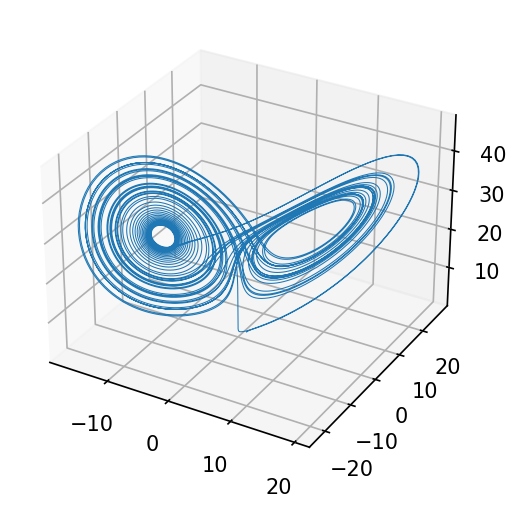

In [35]:
def f(state, t, rho, sigma, beta):
    x, y, z = state 
    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

f = partial(f, rho=28.0, sigma=10.0, beta=8.0/3.0)
t = jnp.linspace(0, 50, 10000)
state0 = jnp.array([1.0, 1.0, 1.0])

ys = odeint(f, state0, t)

import matplotlib.pyplot as plt

def plot_3d_path(ax, ys, color):
  x0, x1, x2 = ys.T
  ax.plot(x0, x1, x2, lw=0.5, color=color)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(111, projection='3d')
plot_3d_path(ax, ys, color='C0')